# Kats 204 Forecasting with Meta-Learning

This tutorial will introduce the meta-learning framework for forecasting in Kats.  The table of contents for Kats 204 is as follows:

1.  Overview of Meta-Learning Framework For Forecasting         
2.  Introduction to `GetMetaData`
3.  Determining Predictability with `MetaLearnPredictability`
4.  Model Selection with `MetaLearnModelSelect`       
5.  Hyperparameter Tuning with `MetaLearnHPT`              
    5.1. Initializing `MetaLearnHPT`             
    5.2. `MetaLearnHPT` with Default Neural Network Model Structure      
    5.3. `MetaLearnHPT` with Custom Neural Network Model Structure
 
# For the details of methodology of meta-learning framework and our experiment results, please see the reference https://arxiv.org/pdf/2102.05740.pdf .

**Note:** We provide two types of tutorial notebooks
- **Kats 101**, basic data structure and functionalities in Kats 
- **Kats 20x**, advanced topics, including advanced forecasting techniques, advanced detection algorithms, `TsFeatures`, meta-learning, etc. 

## 1. Overview of Meta-Learning Framework For Forecasting

Suppose we have a time series and we are looking to build the best possible forecast (with respect to a predefined error metric such as mean absolute error) from the following list of candidate models (and possibly other forecasting models in Kats too):
* ARIMA
* SARIMA
* Holt-Winters
* Prophet
* Theta
* STLF



For a single time series, it is straightforward to to do hyperparameter tuning for each of the candidate models with this time series, calculate the error metric, and choose the model that minimizes the error metric.  We have discussed this methodology in detail in Kats 201.  Our basic metadata object, `GetMetaData`, which we will introduce below, also does this calculation to find the best forecasting model for a single time series.

However, when we are working with a large number of time series, repeating this process quickly becomes intractable, and for that, we include a meta-learning framework for forecasting.  There are two key model classes, plus one optional one, in our meta-learning framework:

1. `MetaLearnModelSelect`: Given the metadata for a time series, predict the best model family (from the candidate models of interest) to forecast the series.  This model is a random forest by default.
2. `MetaLearnHPT`: Given a time series and a model type, predict the best parameters for this model.  This model is a neutral network.  
3. `MetaLearnPredictability` (optional): Given the metadata for a time series, predict if it is "predictable", i.e. if it is possible to forecast with a threshold error.  This model is a random forest by default.

For each of these models, you can use labeled training data to build a model or you load a pre-trained model from a file path.  

We use the `GetMetaData` object to represent the metadata for a time series in `MetaLearnModelSelect` and `MetaLearnPredictability`.  This tutorial begins with an introduction to the `GetMetaData` object.  Since this object is heavily dependent on `TsFeatures`, if you are not familiar `TsFeatures`, you should check out Kats 203 prior to continuing with this tutorial.  

Next we will use labeled time series data from the `m3_meta_data.csv` file to show how to use the `MetaLearnPredictability`, `MetaLearnModelSelect` and `MetaLearnPredictability`.  


The sample data in `m3_meta_data.csv` is very small, with 78 labeled examples, so the examples we provide here will not be highly accurate, but they will show you the proper workflow for using the meta-learning framework for forecasting in Kats.


The full table of contents for Kats 204 is as follow

## 2. Introduction to `GetMetaData`

The `GetMetaData` class generates the metadata for any time series.  There are three key components to the the metadata for a time series:
1. `features`: the `TsFeatures` dictionary for the time series
2. `hpt_res`: a dictionary giving the best hyperparameters for each candidate model and the corresponding error metric for the time series 
3. `best_model`: the name of the model with the smallest error metric

The default error metric is mean absolute error (mae) but this can be controlled with the `error_method` argument in `GetMetaData`.  

The list of candidate models that we consider is controlled by the `all_models` argument in `GetMetaData`, which is a dictionary with string names of the candidate models as keys and corresponding model classes as value.

with keys equal to the string names of the models as keys  and values equal to the corresponding model class.  The keys in `hpt_res` and the value of `best_model` come from the keys of the `all_models` dictionary.  The default value of `all_models` will include the following six models.

1. ARIMA
2. SARIMA
3. Holt-Winters
4. Prophet`
5. Theta
6. STLF

Our first example uses the `air_passengers` data set.  We show how to get the metadata for this time series.  We start by loading the time series into a `TimeSeriesData` object.

In [4]:
# %%capture
# # For Google Colab:
# !pip install kats
# !wget https://raw.githubusercontent.com/facebookresearch/Kats/main/kats/data/air_passengers.csv
# !wget https://raw.githubusercontent.com/facebookresearch/Kats/main/kats/data/m3_meta_data.csv

In [5]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore')
sys.path.append("../")

from kats.consts import TimeSeriesData

try: # If running on Jupyter
    air_passengers_df = pd.read_csv("../data/air_passengers.csv")
except FileNotFoundError: # If running on colab
    air_passengers_df = pd.read_csv("air_passengers.csv")
    
air_passengers_df.columns = ["time", "value"]
air_passengers_ts = TimeSeriesData(air_passengers_df)

Now we can construct the `GetMetaData` object for the `air_passengers` data set time series like follows.  We use all of the default settings except that we use mean absolute percentage error (mape) as our error metric rather than the default of mean absolute error (mae) 

In [6]:
from kats.models.metalearner.get_metadata import GetMetaData

# create an object MD of class GetMetaData with error method mean absolute percentage error (mape)
MD = GetMetaData(data=air_passengers_ts, error_method='mape')

Let's take a look at the `all_models` dictionary that is used by default here.  You are allowed to specify your own `all_models` dictionary as long as all the values are classes that extends the abstract class `kats.models.Model`.

In [7]:
MD.all_models

{'arima': kats.models.arima.ARIMAModel,
 'holtwinters': kats.models.holtwinters.HoltWintersModel,
 'prophet': kats.models.prophet.ProphetModel,
 'theta': kats.models.theta.ThetaModel,
 'stlf': kats.models.stlf.STLFModel,
 'sarima': kats.models.sarima.SARIMAModel}

The `all_params` dictionary will have the same keys as the `all_models` dictionary, and the values are the corresponding parameter class (i.e. a class that extends the class `kats.const.Params`)

In [8]:
MD.all_params

{'arima': kats.models.arima.ARIMAParams,
 'holtwinters': kats.models.holtwinters.HoltWintersParams,
 'prophet': kats.models.prophet.ProphetParams,
 'theta': kats.models.theta.ThetaParams,
 'stlf': kats.models.stlf.STLFParams,
 'sarima': kats.models.sarima.SARIMAParams}

Now we can use the `get_meta_data` function to calculate all the metadata and output the result as a dictionary.

In [9]:
# get meta data as a dictionary
air_passengers_metadata = MD.get_meta_data()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.06291D+00    |proj g|=  4.34657D+00

At iterate    5    f= -2.06380D+00    |proj g|=  5.59738D-01

At iterate   10    f= -2.06523D+00    |proj g|=  3.03566D+00

At iterate   15    f= -2.06570D+00    |proj g|=  2.45659D-01

At iterate   20    f= -2.06632D+00    |proj g|=  1.49260D+00


 This problem is unconstrained.



At iterate   25    f= -2.06691D+00    |proj g|=  1.63433D-01

At iterate   30    f= -2.06699D+00    |proj g|=  2.00792D-01

At iterate   35    f= -2.06869D+00    |proj g|=  8.79699D-01

At iterate   40    f= -2.06966D+00    |proj g|=  1.41038D-02

At iterate   45    f= -2.07010D+00    |proj g|=  9.35611D-02

At iterate   50    f= -2.07060D+00    |proj g|=  5.01889D-02

At iterate   55    f= -2.07076D+00    |proj g|=  2.26065D-02

At iterate   60    f= -2.07092D+00    |proj g|=  2.01618D-02

At iterate   65    f= -2.07093D+00    |proj g|=  1.62470D-01

At iterate   70    f= -2.07131D+00    |proj g|=  5.24708D-01

At iterate   75    f= -2.07166D+00    |proj g|=  3.85783D-01

At iterate   80    f= -2.07169D+00    |proj g|=  1.33358D-01

At iterate   85    f= -2.07170D+00    |proj g|=  1.16134D-03

At iterate   90    f= -2.07170D+00    |proj g|=  1.49214D-05

At iterate   95    f= -2.07170D+00    |proj g|=  9.54792D-06

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.



At iterate   40    f= -1.81703D+00    |proj g|=  1.79257D-01

At iterate   45    f= -1.81703D+00    |proj g|=  3.30143D-02

At iterate   50    f= -1.81703D+00    |proj g|=  1.73694D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     54     67      1     0     0   2.358D-05  -1.817D+00
  F =  -1.8170319863295508     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.87829D+00    |proj g|=  3.90799D+01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.76868D+00    |proj g|=  6.36423D-02

At iterate   10    f= -1.76868D+00    |proj g|=  1.17223D+00

At iterate   15    f= -1.76883D+00    |proj g|=  1.14006D+01

At iterate   20    f= -1.76941D+00    |proj g|=  4.98468D-02

At iterate   25    f= -1.76941D+00    |proj g|=  1.44938D-02

At iterate   30    f= -1.76941D+00    |proj g|=  2.18956D-01

At iterate   35    f= -1.76941D+00    |proj g|=  1.43069D+00

At iterate   40    f= -1.76942D+00    |proj g|=  1.80276D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     44     54      1     0     0   4.174D-05  -1.769D+00
  F =  -1.76941921928

 This problem is unconstrained.



At iterate   35    f= -1.81747D+00    |proj g|=  3.59314D+00

At iterate   40    f= -1.81748D+00    |proj g|=  1.79589D-02

At iterate   45    f= -1.81748D+00    |proj g|=  3.25125D-01

At iterate   50    f= -1.81750D+00    |proj g|=  2.95402D+00

At iterate   55    f= -1.81755D+00    |proj g|=  3.75416D-02

At iterate   60    f= -1.81755D+00    |proj g|=  1.11399D-02

At iterate   65    f= -1.81755D+00    |proj g|=  1.51512D-01

At iterate   70    f= -1.81755D+00    |proj g|=  2.79525D-01

At iterate   75    f= -1.81755D+00    |proj g|=  5.30123D-03

At iterate   80    f= -1.81755D+00    |proj g|=  5.94002D-02

At iterate   85    f= -1.81755D+00    |proj g|=  1.37418D-01

At iterate   90    f= -1.81756D+00    |proj g|=  2.07485D-02

At iterate   95    f= -1.81756D+00    |proj g|=  9.43214D-03

At iterate  100    f= -1.81756D+00    |proj g|=  7.83357D-02

At iterate  105    f= -1.81756D+00    |proj g|=  6.98175D-04

At iterate  110    f= -1.81756D+00    |proj g|=  3.38036D-03

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.94702D+00    |proj g|=  1.51425D+02

At iterate    5    f= -1.94733D+00    |proj g|=  8.87820D-01

At iterate   10    f= -1.94734D+00    |proj g|=  1.39677D+01

At iterate   15    f= -1.94762D+00    |proj g|=  1.25156D+02

At iterate   20    f= -1.94840D+00    |proj g|=  9.38786D-02

At iterate   25    f= -1.94840D+00    |proj g|=  6.96681D+00

At iterate   30    f= -1.94857D+00    |proj g|=  8.89702D+01

At iterate   35    f= -1.95040D+00    |proj g|=  3.94246D+01

At iterate   40    f= -1.95048D+00    |proj g|=  9.50668D-03

At iterate   45    f= -1.95048D+00    |proj g|=  1.69294D-01

At iterate   50    f= -1.95051D+00    |proj g|=  8.93731D+00

At iterate   55    f= -1.95090D+00    |proj g|=  3.03867D+00

At iterate   60    f= -1.95091D+00    |proj g|=  2.02500D-02

At iterate   65    f= -1.9

 This problem is unconstrained.



At iterate   55    f= -1.80619D+00    |proj g|=  1.27156D-02

At iterate   60    f= -1.80619D+00    |proj g|=  4.21643D-02

At iterate   65    f= -1.80619D+00    |proj g|=  2.05835D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     67     96      1     0     0   5.240D-06  -1.806D+00
  F =  -1.8061900768786734     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=          NaN    |proj g|=          NaN


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.87687D+00    |proj g|=  4.03373D+00

At iterate    5    f= -1.87690D+00    |proj g|=  9.45460D-01

At iterate   10    f= -1.87724D+00    |proj g|=  1.38355D+01

At iterate   15    f= -1.87969D+00    |proj g|=  1.10272D-01

At iterate   20    f= -1.87981D+00    |proj g|=  6.30605D-01

At iterate   25    f= -1.88046D+00    |proj g|=  7.81511D-02


 This problem is unconstrained.



At iterate   30    f= -1.88152D+00    |proj g|=  6.66729D-03

At iterate   35    f= -1.88152D+00    |proj g|=  4.12289D-01

At iterate   40    f= -1.88157D+00    |proj g|=  4.80405D+00

At iterate   45    f= -1.88253D+00    |proj g|=  4.54644D+00

At iterate   50    f= -1.88262D+00    |proj g|=  2.44783D-02

At iterate   55    f= -1.88262D+00    |proj g|=  2.81225D-02

At iterate   60    f= -1.88262D+00    |proj g|=  1.40378D-01

At iterate   65    f= -1.88262D+00    |proj g|=  5.37739D-03

At iterate   70    f= -1.88262D+00    |proj g|=  2.42584D-01

At iterate   75    f= -1.88273D+00    |proj g|=  1.27127D+00

At iterate   80    f= -1.88370D+00    |proj g|=  3.09217D-01

At iterate   85    f= -1.88371D+00    |proj g|=  1.31686D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized 

 This problem is unconstrained.



At iterate   35    f= -1.92110D+00    |proj g|=  3.22544D-02

At iterate   40    f= -1.92111D+00    |proj g|=  4.39346D-01

At iterate   45    f= -1.92115D+00    |proj g|=  5.71314D-02

At iterate   50    f= -1.92115D+00    |proj g|=  1.51753D-02

At iterate   55    f= -1.92115D+00    |proj g|=  1.63742D-03

At iterate   60    f= -1.92115D+00    |proj g|=  1.82787D-02

At iterate   65    f= -1.92115D+00    |proj g|=  1.11220D-03

At iterate   70    f= -1.92115D+00    |proj g|=  3.08402D-02

At iterate   75    f= -1.92115D+00    |proj g|=  6.15175D-04

At iterate   80    f= -1.92115D+00    |proj g|=  8.93841D-04

At iterate   85    f= -1.92115D+00    |proj g|=  3.40408D-03

At iterate   90    f= -1.92115D+00    |proj g|=  2.60370D-02

At iterate   95    f= -1.92115D+00    |proj g|=  4.39049D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.80205D+00    |proj g|=  1.81811D+01

At iterate    5    f= -1.80245D+00    |proj g|=  6.56462D-01

At iterate   10    f= -1.80256D+00    |proj g|=  8.46113D+00

At iterate   15    f= -1.80296D+00    |proj g|=  9.39455D-03

At iterate   20    f= -1.80299D+00    |proj g|=  2.11336D+00

At iterate   25    f= -1.80481D+00    |proj g|=  1.21183D+01

At iterate   30    f= -1.80571D+00    |proj g|=  8.31108D-02

At iterate   35    f= -1.80571D+00    |proj g|=  3.67470D-01

At iterate   40    f= -1.80571D+00    |proj g|=  9.98979D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate   30    f= -2.00863D+00    |proj g|=  6.42251D-02

At iterate   35    f= -2.00863D+00    |proj g|=  6.19993D-04

At iterate   40    f= -2.00863D+00    |proj g|=  3.15303D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     41     54      1     0     0   7.017D-06  -2.009D+00
  F =  -2.0086315744196312     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.89807D+00    |proj g|=  7.48226D+00

At iter

 This problem is unconstrained.



At iterate   55    f= -1.90732D+00    |proj g|=  5.29554D-04

At iterate   60    f= -1.90732D+00    |proj g|=  3.51412D-03

At iterate   65    f= -1.90732D+00    |proj g|=  2.65672D-01

At iterate   70    f= -1.90741D+00    |proj g|=  1.43268D+00

At iterate   75    f= -1.90746D+00    |proj g|=  1.16802D-03

At iterate   80    f= -1.90746D+00    |proj g|=  1.29041D-01

At iterate   85    f= -1.90747D+00    |proj g|=  1.98440D-02

At iterate   90    f= -1.90748D+00    |proj g|=  4.19961D-02

At iterate   95    f= -1.90751D+00    |proj g|=  1.14689D-01

At iterate  100    f= -1.90751D+00    |proj g|=  2.94671D-02

At iterate  105    f= -1.90751D+00    |proj g|=  1.00330D-01

At iterate  110    f= -1.90751D+00    |proj g|=  4.66337D-02

At iterate  115    f= -1.90752D+00    |proj g|=  4.04801D-03

At iterate  120    f= -1.90752D+00    |proj g|=  5.23561D-03

At iterate  125    f= -1.90752D+00    |proj g|=  1.80980D-02

At iterate  130    f= -1.90752D+00    |proj g|=  1.43290D-03

       

 This problem is unconstrained.



At iterate   20    f= -1.95748D+00    |proj g|=  1.71654D+00

At iterate   25    f= -1.95755D+00    |proj g|=  4.90265D+00

At iterate   30    f= -1.95782D+00    |proj g|=  1.23272D-02

At iterate   35    f= -1.95782D+00    |proj g|=  8.81383D-01

At iterate   40    f= -1.95803D+00    |proj g|=  2.58051D+00

At iterate   45    f= -1.95819D+00    |proj g|=  4.01835D-02

At iterate   50    f= -1.95903D+00    |proj g|=  2.06623D+00

At iterate   55    f= -1.98013D+00    |proj g|=  2.34007D+00

At iterate   60    f= -1.98470D+00    |proj g|=  5.18148D+00

At iterate   65    f= -1.98506D+00    |proj g|=  9.34338D-01

At iterate   70    f= -1.98518D+00    |proj g|=  1.41230D-02

At iterate   75    f= -1.98518D+00    |proj g|=  7.04164D-02

At iterate   80    f= -1.98525D+00    |proj g|=  4.26027D-01

At iterate   85    f= -1.98534D+00    |proj g|=  4.22746D-02

At iterate   90    f= -1.98534D+00    |proj g|=  1.80704D-02

At iterate   95    f= -1.98534D+00    |proj g|=  6.07470D-03

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  265    f= -1.98564D+00    |proj g|=  6.50298D-01

At iterate  270    f= -1.98564D+00    |proj g|=  6.74374D-03

At iterate  275    f= -1.98564D+00    |proj g|=  1.48290D-01

At iterate  280    f= -1.98565D+00    |proj g|=  6.74009D-01

At iterate  285    f= -1.98565D+00    |proj g|=  7.09732D-03

At iterate  290    f= -1.98566D+00    |proj g|=  5.61942D-01

At iterate  295    f= -1.98567D+00    |proj g|=  2.93028D-02

At iterate  300    f= -1.98567D+00    |proj g|=  8.02785D-01

At iterate  305    f= -1.98567D+00    |proj g|=  4.47931D-03

At iterate  310    f= -1.98567D+00    |proj g|=  1.64084D-03

At iterate  315    f= -1.98567D+00    |proj g|=  3.07709D-03

At iterate  320    f= -1.98567D+00    |proj g|=  7.24785D-03

At iterate  325    f= -1.98567D+00    |proj g|=  9.71272D-02

At iterate  330    f= -1.98568D+00    |proj g|=  8.89150D-02

At iterate  335    f= -1.98569D+00    |proj g|=  3.15223D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.90068D+00    |proj g|=  6.56601D+01

At iterate    5    f= -1.91667D+00    |proj g|=  2.48898D+00

At iterate   10    f= -1.91668D+00    |proj g|=  2.26028D+00


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     14     63      1     0     0   3.452D+00  -1.917D+00
  F =  -1.9166824088759002     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.96838D+00    |proj g|=  5.12130D+01

At iterate    5    f= -1.97711D+00    |proj g|=  2.47243D-01

At iterate   10    f= -1.97845D+00    |proj g|=  2.59634D+00

At iterate   15    f= -1.98032D+00    |proj g|=  1.40732D+00

At iterate   20    f= -1.98070D+00    |proj g|=  9.75958D-02
  ys=-1.719E-14  -gs= 1.747E-14 BFGS update SKIPPED

At iterate   25    f= -1.98070D+00    |proj g|=  5.37453D-02

At iterate   30    f= -1.98081D+00    |proj g|=  8.79834D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   35    f= -1.98296D+00    |proj g|=  1.41752D-01

At iterate   40    f= -1.98320D+00    |proj g|=  5.76328D-01

At iterate   45    f= -1.98333D+00    |proj g|=  8.01177D-02

At iterate   50    f= -1.98443D+00    |proj g|=  2.67372D+00

At iterate   55    f= -1.98629D+00    |proj g|=  1.58331D+01

At iterate   60    f= -1.98772D+00    |proj g|=  3.60596D-01

At iterate   65    f= -1.98772D+00    |proj g|=  7.71415D-02

At iterate   70    f= -1.98774D+00    |proj g|=  1.53457D-01

At iterate   75    f= -1.98811D+00    |proj g|=  1.71351D+00

At iterate   80    f= -1.98908D+00    |proj g|=  3.81842D+00

At iterate   85    f= -1.98974D+00    |proj g|=  4.09499D+00

At iterate   90    f= -1.98980D+00    |proj g|=  2.36451D-02

At iterate   95    f= -1.98982D+00    |proj g|=  1.45468D+00

At iterate  100    f= -1.99048D+00    |proj g|=  1.71070D+00

At iterate  105    f= -1.99061D+00    |proj g|=  1.25981D+00

At iterate  110    f= -2.00203D+00    |proj g|=  1.29795D+01

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.79947D+00    |proj g|=  5.73252D+01

At iterate    5    f= -1.80274D+00    |proj g|=  5.10944D-01

At iterate   10    f= -1.80279D+00    |proj g|=  6.98340D+00

At iterate   15    f= -1.80373D+00    |proj g|=  3.65332D+00

At iterate   20    f= -1.80377D+00    |proj g|=  2.19253D+00

At iterate   25    f= -1.80908D+00    |proj g|=  4.48318D+01

At iterate   30    f= -1.81167D+00    |proj g|=  7.07644D-02

At iterate   35    f= -1.81592D+00    |proj g|=  2.53837D+00

At iterate   40    f= -1.81595D+00    |proj g|=  1.11549D-03

At iterate   45    f= -1.81595D+00    |proj g|=  4.03844D-02

At iterate   50    f= -1.81595D+00    |proj g|=  5.11854D-01


 This problem is unconstrained.



At iterate   55    f= -1.81597D+00    |proj g|=  1.66534D-01

At iterate   60    f= -1.81635D+00    |proj g|=  1.99211D+00

At iterate   65    f= -1.81651D+00    |proj g|=  6.13242D-01

At iterate   70    f= -1.81652D+00    |proj g|=  3.70359D-02

At iterate   75    f= -1.81653D+00    |proj g|=  6.52340D-03

At iterate   80    f= -1.81653D+00    |proj g|=  6.81350D-02

At iterate   85    f= -1.81653D+00    |proj g|=  5.72280D-02

At iterate   90    f= -1.81653D+00    |proj g|=  9.86420D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     93    125      1     0     0   1.712D-03  -1.817D+00
  F =  -1.81652577334

 This problem is unconstrained.



At iterate   25    f= -2.00422D+00    |proj g|=  9.60379D-01

At iterate   30    f= -2.00611D+00    |proj g|=  4.28632D-01

At iterate   35    f= -2.00613D+00    |proj g|=  4.47082D-02

At iterate   40    f= -2.00614D+00    |proj g|=  2.52857D-01

At iterate   45    f= -2.00665D+00    |proj g|=  4.27234D+00

At iterate   50    f= -2.00718D+00    |proj g|=  1.09962D+00

At iterate   55    f= -2.00779D+00    |proj g|=  2.20939D+00

At iterate   60    f= -2.00816D+00    |proj g|=  8.33026D-01

At iterate   65    f= -2.00817D+00    |proj g|=  5.70344D-03

At iterate   70    f= -2.00825D+00    |proj g|=  1.33557D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   75    f= -2.00854D+00    |proj g|=  8.64379D-01

At iterate   80    f= -2.00854D+00    |proj g|=  1.74627D-02

At iterate   85    f= -2.00854D+00    |proj g|=  3.50209D-01

At iterate   90    f= -2.00856D+00    |proj g|=  2.43333D-02

At iterate   95    f= -2.00856D+00    |proj g|=  7.74301D-03

At iterate  100    f= -2.00856D+00    |proj g|=  1.78476D-01

At iterate  105    f= -2.00857D+00    |proj g|=  5.70198D-01

At iterate  110    f= -2.00857D+00    |proj g|=  5.17977D-03

At iterate  115    f= -2.00857D+00    |proj g|=  9.95914D-04

At iterate  120    f= -2.00857D+00    |proj g|=  3.18519D-02

At iterate  125    f= -2.00857D+00    |proj g|=  1.11540D-02

At iterate  130    f= -2.00857D+00    |proj g|=  5.94489D-02

At iterate  135    f= -2.00857D+00    |proj g|=  1.89626D-04

At iterate  140    f= -2.00857D+00    |proj g|=  7.67830D-04

At iterate  145    f= -2.00857D+00    |proj g|=  3.38400D-03

At iterate  150    f= -2.00857D+00    |proj g|=  2.27523D-02

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=          NaN    |proj g|=          NaN
Initial log joint probability = -3.40261
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       422.246     0.0180658       213.125      0.4914           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       429.759     0.0165888       337.073      0.3576           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       435.263    0.00952663       135.141           1           1      362   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       437.191    0.00232536       195.578      0.1515           1      476   
    Iter      

Initial log joint probability = -3.40261
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -3.40261           nan       119.845       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -23.4284
Iteration  1. Log joint probability =    108.265. Improved by 131.694.
Iteration  2. Log joint probability =    172.823. Improved by 64.5578.
Iteration  3. Log joint probability =    184.734. Improved by 11.9109.
Iteration  4. Log joint probability =    297.255. Improved by 112.521.
Iteration  5. Log joint probability =    299.179. Improved by 1.92456.
Iteration  6. Log joint probability =    306.469. Improved by 7.28984.
Iteration  7. Log joint probability =      312.1. Improved by 5.63039.
Iteration  8. Log joint probability =    312.866. Improved by 0.766318.
Iteration  9. Log joint probability =    312.965

Initial log joint probability = -3.40261
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -3.40261           nan       119.655       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -41.99
Iteration  1. Log joint probability =    72.3333. Improved by 114.323.
Iteration  2. Log joint probability =    157.165. Improved by 84.8319.
Iteration  3. Log joint probability =    217.404. Improved by 60.2384.
Iteration  4. Log joint probability =    243.143. Improved by 25.7397.
Iteration  5. Log joint probability =    292.801. Improved by 49.6573.
Iteration  6. Log joint probability =    336.461. Improved by 43.6602.
Iteration  7. Log joint probability =    338.198. Improved by 1.73737.
Iteration  8. Log joint probability =     340.01. Improved by 1.81167.
Iteration  9. Log joint probability =    340.763. I

Initial log joint probability = -3.40261
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       367.732   1.30916e-05       346.615       9.199      0.9199      142   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       367.752   7.40871e-06       301.394   2.203e-08       0.001      242  LS failed, Hessian reset 
     183       367.753   4.55652e-08        260.81   1.136e-10       0.001      335  LS failed, Hessian reset 
     186       367.753   3.42757e-09       329.247      0.2073      0.2073      339   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -3.40261
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       245.053     0.0127993       50.6167      0.6666           1      138   
    Iter      log prob        ||dx||      ||grad||    

Initial log joint probability = -3.40261
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -3.40261           nan       121.461       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = 60.3732
Iteration  1. Log joint probability =    36.3777. Improved by -23.9955.
Iteration  2. Log joint probability =    89.9266. Improved by 53.5489.
Iteration  3. Log joint probability =    174.311. Improved by 84.3843.
Iteration  4. Log joint probability =    231.357. Improved by 57.0463.
Iteration  5. Log joint probability =    233.285. Improved by 1.92796.
Iteration  6. Log joint probability =     242.28. Improved by 8.99527.
Iteration  7. Log joint probability =    242.366. Improved by 0.0853861.
Iteration  8. Log joint probability =    242.613. Improved by 0.247144.
Iteration  9. Log joint probability =    242.6

Initial log joint probability = -3.40261
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -3.40261           nan       119.415       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = 40.0832
Iteration  1. Log joint probability =    85.5613. Improved by 45.4781.
Iteration  2. Log joint probability =    179.393. Improved by 93.8316.
Iteration  3. Log joint probability =    225.606. Improved by 46.2134.
Iteration  4. Log joint probability =    228.973. Improved by 3.36698.
Iteration  5. Log joint probability =    234.648. Improved by 5.67461.
Iteration  6. Log joint probability =    239.475. Improved by 4.82716.
Iteration  7. Log joint probability =    240.143. Improved by 0.667579.
Iteration  8. Log joint probability =    241.389. Improved by 1.24593.
Iteration  9. Log joint probability =    241.847.

Initial log joint probability = -3.40261
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -3.40261           nan       121.383       1e-12       0.001       24   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = 49.6697
Iteration  1. Log joint probability =    37.5425. Improved by -12.1272.
Iteration  2. Log joint probability =    92.8688. Improved by 55.3263.
Iteration  3. Log joint probability =    193.363. Improved by 100.494.
Iteration  4. Log joint probability =    255.288. Improved by 61.9256.
Iteration  5. Log joint probability =    331.912. Improved by 76.624.
Iteration  6. Log joint probability =    347.105. Improved by 15.1927.
Iteration  7. Log joint probability =    349.107. Improved by 2.00156.
Iteration  8. Log joint probability =    349.811. Improved by 0.704687.
Iteration  9. Log joint probability =    350.633.

Initial log joint probability = -3.40261
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       289.488    0.00879194       110.421      0.5436           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     189       291.199    0.00017594       49.5392   8.858e-07       0.001      264  LS failed, Hessian reset 
     199       291.406   0.000492258       59.0175           1           1      277   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       291.778   4.48659e-06       15.0059           1           1      413   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       291.993   0.000819002       20.3071           1           1      539   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       292.024   0.000269608    

Initial log joint probability = -3.40261
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -3.40261           nan       122.923       1e-12       0.001       24   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = 49.6697
Iteration  1. Log joint probability =    94.1411. Improved by 44.4714.
Iteration  2. Log joint probability =    176.486. Improved by 82.3447.
Iteration  3. Log joint probability =    257.216. Improved by 80.73.
Iteration  4. Log joint probability =    310.246. Improved by 53.0306.
Iteration  5. Log joint probability =    311.797. Improved by 1.55016.
Iteration  6. Log joint probability =    312.867. Improved by 1.07015.
Iteration  7. Log joint probability =    313.235. Improved by 0.368509.
Iteration  8. Log joint probability =    313.511. Improved by 0.275684.
Iteration  9. Log joint probability =    313.716. 

Initial log joint probability = -3.40261
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -3.40261           nan       119.685       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = 20.895
Iteration  1. Log joint probability =    85.5607. Improved by 64.6657.
Iteration  2. Log joint probability =    184.978. Improved by 99.4172.
Iteration  3. Log joint probability =     230.24. Improved by 45.2625.
Iteration  4. Log joint probability =    234.984. Improved by 4.74334.
Iteration  5. Log joint probability =    239.631. Improved by 4.64735.
Iteration  6. Log joint probability =    239.975. Improved by 0.343857.
Iteration  7. Log joint probability =    240.122. Improved by 0.14712.
Iteration  8. Log joint probability =    241.673. Improved by 1.55104.
Iteration  9. Log joint probability =    241.783. 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.16854
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       390.798    0.00102171        148.23           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     184       393.433   0.000113917       88.5011   1.042e-06       0.001      269  LS failed, Hessian reset 
     199       393.453   1.18395e-05        67.101      0.6432      0.6432      292   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     230       393.827   0.000171812       123.183   9.136e-07       0.001      369  LS failed, Hessian reset 
     299       394.415   0.000700583       124.644     0.02966      0.6732      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     314       394.627   0.000401414       175.303   5.225e-06       0.001      521  LS failed, Hessian rese

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.16854
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       390.798    0.00102171        148.23           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     184       393.433   0.000113917       88.5011   1.042e-06       0.001      269  LS failed, Hessian reset 
     199       393.453   1.18395e-05        67.101      0.6432      0.6432      292   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     230       393.827   0.000171812       123.183   9.136e-07       0.001      369  LS failed, Hessian reset 
     299       394.415   0.000700583       124.644     0.02966      0.6732      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     314       394.627   0.000401414       175.303   5.225e-06       0.001      521  LS failed, Hessian rese

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.16854
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       390.798    0.00102171        148.23           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     184       393.433   0.000113917       88.5011   1.042e-06       0.001      269  LS failed, Hessian reset 
     199       393.453   1.18395e-05        67.101      0.6432      0.6432      292   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     230       393.827   0.000171812       123.183   9.136e-07       0.001      369  LS failed, Hessian reset 
     299       394.415   0.000700583       124.644     0.02966      0.6732      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     314       394.627   0.000401414       175.303   5.225e-06       0.001      521  LS failed, Hessian rese

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.16854
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       390.798    0.00102171        148.23           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     184       393.433   0.000113917       88.5011   1.042e-06       0.001      269  LS failed, Hessian reset 
     199       393.453   1.18395e-05        67.101      0.6432      0.6432      292   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     230       393.827   0.000171812       123.183   9.136e-07       0.001      369  LS failed, Hessian reset 
     299       394.415   0.000700583       124.644     0.02966      0.6732      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     314       394.627   0.000401414       175.303   5.225e-06       0.001      521  LS failed, Hessian rese

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.16854
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       390.798    0.00102171        148.23           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     184       393.433   0.000113917       88.5011   1.042e-06       0.001      269  LS failed, Hessian reset 
     199       393.453   1.18395e-05        67.101      0.6432      0.6432      292   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     230       393.827   0.000171812       123.183   9.136e-07       0.001      369  LS failed, Hessian reset 
     299       394.415   0.000700583       124.644     0.02966      0.6732      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     314       394.627   0.000401414       175.303   5.225e-06       0.001      521  LS failed, Hessian rese

Let's take a look at the keys of the metadata dictionary.

In [10]:
air_passengers_metadata.keys()

dict_keys(['hpt_res', 'features', 'best_model', 'search_method', 'error_method'])

We explained what `features`, `hpt_res` and `best_model` are above.  This dictionary also includes the `search_method` and `error_method`, which will just be the default values in this case.  We can see these as follows.

In [11]:
print(f"search_method: {air_passengers_metadata['search_method']}")
print(f"error_method: {air_passengers_metadata['error_method']}")

search_method: RandomSearch
error_method: mape


The keys of the `hpt_res` dictionary are name of the candidate model families; they should be the same as the keys for the `all_models` and `all_parameters` dictionaries. 

In [12]:
air_passengers_metadata['hpt_res'].keys()

dict_keys(['arima', 'holtwinters', 'prophet', 'theta', 'stlf', 'sarima'])

The values of the `hpt_res` dictionary are two-element tuples.  The first element is gives the hyperparameters that minimize the error metric.  The second element gives the corresponding minimum error metric.  Let's take a look at these values for ARIMA:

In [13]:
air_passengers_metadata['hpt_res']['arima']

({'p': 4, 'd': 1, 'q': 3}, 0.10616511652054089)

We can sort the different methods by their error metric as follows:

In [14]:
methods = list(air_passengers_metadata['hpt_res'].keys())
sorted(methods, key = lambda m: air_passengers_metadata['hpt_res'][m][1])

['prophet', 'stlf', 'holtwinters', 'theta', 'arima', 'sarima']

This suggests that Prophet has the lowest error metric.  Let's confirm that this is what `best_model` indicates:

In [15]:
air_passengers_metadata['best_model']

'prophet'

We constructed the `GetMetaData` object for the `air_passengers` data set with all of the default settings.  Let's take a look at the full set of attributes that can be used to initialize `GetMetadata`.

This is the only required attributed: 
* **data**: TimeSeriesData, the time series for which we calculate the metadata

The following attributes are all optional:
* **all_models**: `Dict[str, m.Model]`, a dictionary for the candidate model classes.  The key is a string naming the model and each value is a corresponding model class (i.e. a class that extends the abstract class `kats.models.Model`).
* **all_params**: `Dict[str, Params]`, a dictionary for the candidate model parameter classes.  The keys are the same as the keys for `all_models` and each value is a corresponding parameter class (i.e. a class that extends the class `kats.const.Params`).
* **min_length**: int, the minimal length of time series. We raise a value error if the length of `data` is smaller than `min_length`.  The default value of `min_length` is 30.
* **scale**: bool, Whether to rescale the time series by its maximum value; default is true.
* **method**: SearchMethodEnum, Search method for hyper-parameters tuning; default is random search in the default parameter space
* **executor**: Callable, A parallel executor for parallel processing.  By default, we use Python's native multiprocessing implementation.
* **error_method**: str, Type of error metric.  Options are `'mape`', `'smape`',`'mae`', `'mase`', `'mse`', `'rmse`';  default is `'mae'`.
* **num_trials**: int, Number of trials for hyperparameter search; default is 5
* **num_arm**: optional Number of arms in hyperparameter search; default is 4.

For the remaining examples, we use the sample data in `m3_meta_data.csv` to show how to build meta-learning models.  This sample data set contains the metadata for 78 time series, meaning it has that we need to construct 78 metadata dictionaries like the one we constructed for the `air_passengers` data set.  While 78 metadata objects is certainly too few to develop an accurate meta-learning model and you should use more examples for your own meta-learning models to get high accuracy, these examples will help familiarize you with our meta-learning framework.

Loading this data is straightforward is straightforward.  After loading it into a `DataFrame`, we have to do some pre-processing with the `eval` function to ensure that the dictionaries are represented as dictionaries and not as strings.  We demonstrate this as follows:

In [17]:
# load the metadata into a DataFrame
try: # If running on Jupyter
    metadata_df = pd.read_csv("../data/m3_meta_data.csv")
except FileNotFoundError: # If running on colab
    metadata_df = pd.read_csv("m3_meta_data.csv")

# We need to do a little pre-processing to make sure the dictionaries are represented as dictionaries
# rather than as strings.  This function will do that pre-processing.
def change_format(tmp):
    tmp['hpt_res']=eval(tmp['hpt_res'])
    tmp['hpt_res']['sarima'][0]['seasonal_order'] = eval(tmp['hpt_res']['sarima'][0]['seasonal_order'])
    tmp['features']=eval(tmp['features'])
    return tmp

metadata_df = metadata_df.apply(change_format, axis=1)

Let's preview the metadata `DataFrame` we just loaded.

In [18]:
metadata_df.head()

,hpt_res,features,best_model,search_method,error_method,idx
0,"{'arima': ({'p': 5, 'd': 2, 'q': 5}, 0.8932924...","{'length': 68, 'mean': 0.35392156862745106, 'v...",stlf,RandomSearch,mape,N1402
1,"{'arima': ({'p': 5, 'd': 2, 'q': 1}, 0.3989958...","{'length': 68, 'mean': 0.19995256166982928, 'v...",arima,RandomSearch,mape,N1403
2,"{'arima': ({'p': 1, 'd': 2, 'q': 3}, 0.2519500...","{'length': 68, 'mean': 0.48962530217566486, 'v...",holtwinters,RandomSearch,mape,N1404
3,"{'arima': ({'p': 2, 'd': 1, 'q': 3}, 0.3146896...","{'length': 68, 'mean': 0.2980870396939263, 'va...",stlf,RandomSearch,mape,N1405
4,"{'arima': ({'p': 3, 'd': 1, 'q': 1}, 0.1448053...","{'length': 68, 'mean': 0.5336050082683677, 'va...",arima,RandomSearch,mape,N1406


Let's convert this metadata `DataFrame` into a list of metadata dictionaries.

In [19]:
metadata_list = metadata_df.to_dict(orient='records')

## 3. Determining Predictability with `MetaLearnPredictability`

Before using meta-learning models for model selection and hyper-parameter forecasting, we would like to know if our target time series is predictable.  The `MetaLearnPredictability` module allows us to treat this like a binary classification problem and build a model for it.  We train this model using a list of a metadata and a threshold for the error metric.  We use the threshold to label each metadata dictionary as predictable if and only if the error of it's `best_model` is smaller than the input threshold.  The arguments for `MetaLearnPredictability` are as follows:


* **metadata**: A list of dictionaries representing the meta-data of time series (e.g., the meta-data generated by GetMetaData object).  Required unless `load_model=True`.

* **threshold**: Float; the threshold for the forecasting error. A time series whose forecasting error of the best forecasting model is higher than the threshold is considered as unpredictable. Default is 0.2.

* **load_model**: Boolean; whether or not to load a trained model. Default is False.


If we want to train a new predictability model from a list of metadata dictionaries, we should include that list in the `metadata` argument.  If we want to load a trained model, we set `load_data=True` and do ignore the `metadata` argument.  We will provide examples of both below.

For our example, we are going to use the sample metadata from the `m3_meta_data.csv` file to train a predictability model with `MetaLearnPredictability`.  Then we will use this to predict whether or not `air_passenger` time series can be forecasted (with MAPE at most 0.2).

We initialize model using the `metadata_list` we previously generated from `m3_meta_data.csv` as follows:

In [20]:
from kats.models.metalearner.metalearner_predictability import MetaLearnPredictability

# take the time series with MAPE>=0.2 as unpreditable time series and initial the object
mlp=MetaLearnPredictability(metadata_list, threshold=0.2)

When we train the model, we see a dictionary with performance metrics calculated on the test data set.

In [21]:
mlp.train()

{'accuracy': 0.8571428571428571,
 'precision': 0.8571428571428571,
 'recall': 1.0,
 'f1': 0.923076923076923}

Now we can use this model to predict if the `air_passenger` time series is predictable.

In [22]:
mlp.pred(air_passengers_ts) 

True

This suggests that this model can be forecast with MAPE at most 0.2.

Let's save the model we trained to a file.

In [23]:
mlp.save_model("mlp.pkl")

Now let's re-load our saved model into a new `MetaLearnPredictability` object.

In [24]:
#initiate a new object and load the trained model
mlp2 = MetaLearnPredictability(load_model=True)
mlp2.load_model("mlp.pkl")

Finally, let's use our newly loaded model to repeat the prediction we did on the `air_passenger` data set.

In [25]:
mlp2.pred(air_passengers_ts) 

True

## 4. **Model Selection with `MetaLearnModelSelect`**

The `MetaLearnModelSelect` object allows you to build a predictive model to determine the best forecasting model for a time series.  It is trained using a list of metadata dictionaries.  The arguments for `MetaLearnModelSelect` are as follows:

* **metadata**: A list of dictionaries representing the meta-data of time series (e.g., the meta-data generated by GetMetaData object).  Required unless `load_model=True`.

* **load_model**: Boolean; whether or not to load a trained model. Default is False.

If we want to train a new predictability model from a list of metadata dictionaries, we should include that list in the `metadata` argument.  If we want to load a trained model, we set `load_data=True` and do ignore the `metadata` argument.  We will provide examples of both below.

For our example, we are going to use the sample metadata from the `m3_meta_data.csv` file to train a selection model with `MetaLearnModelSelect`.  Then we will use this to predict the best forecasting model for the `air_passenger` time series.

We initialize model using the `metadata_list` we previously generated from `m3_meta_data.csv` as follows:

In [26]:
from kats.models.metalearner.metalearner_modelselect import MetaLearnModelSelect

#Initialize the MetaLearnModelSelect object
mlms = MetaLearnModelSelect(metadata_list)

Each metadata dictionary includes a `best_model`, and we can take a look at the frquencies of these models using the `count_category` function.

In [27]:
mlms.count_category()

Counter({'stlf': 22,
         'arima': 11,
         'holtwinters': 16,
         'prophet': 7,
         'sarima': 17,
         'theta': 5})

Before we visualize the data and train the model, it is helpful do some preprocessing.  We can do this with the `preprocess` function.

In [28]:
# pre-process the metadata
# don't down-sample it to balance the classes
# standardize the TsFeatures to have zero mean and unit variance
mlms.preprocess(downsample=False, scale=True)

We can see how the different `TsFeatures` in our metadata objects are correlated with each other by plotting a heatmap, which can be generated using the `plot_corr_heatmap` function.

<AxesSubplot: >

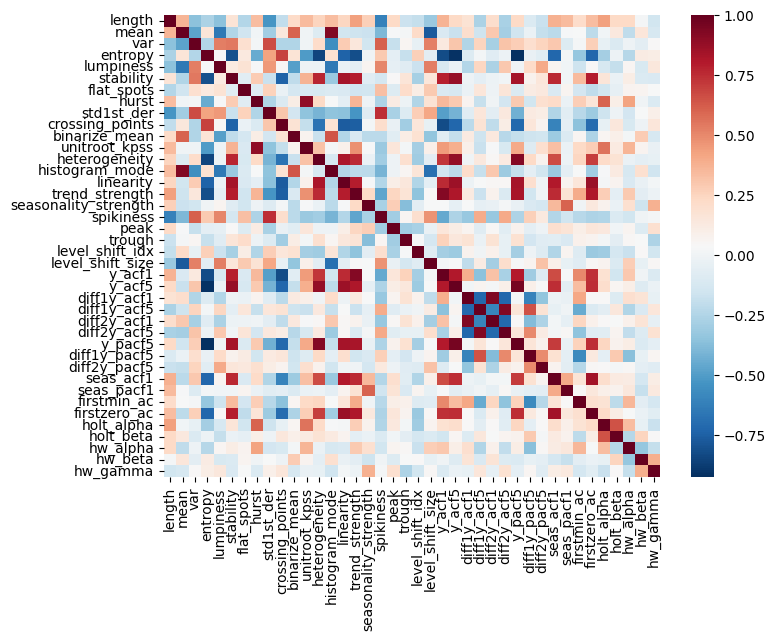

In [29]:
mlms.plot_corr_heatmap()

Now, it is time to train our model.  By default, we will be fitting a random forest model, but other model types (including GBDT, SVT, KNN, Naive Bayes) can be supported using the `method` parameter in the `train` function.  When we run the `train` function, it outputs a dictionary with the training error and test error for each of the candidate models.  All of these error metrics are MAPE because that is the error metric our metadata is using for this example.

In [30]:
# train a modelselect model using random forest algorithm   
results=mlms.train()

# preview the dictionary
results

{'fit_error': {'meta-learn': 0.2630881456984114,
  'stlf': 0.30690519900916896,
  'arima': 0.3742520212915004,
  'holtwinters': 0.3517078269854244,
  'prophet': 0.3306232654084563,
  'sarima': 0.3048037675233225,
  'theta': 0.36594408862769023},
 'pred_error': {'meta-learn': 0.30667756270310476,
  'stlf': 0.3120481354878931,
  'arima': 0.28978215044320615,
  'holtwinters': 0.28150850138844574,
  'prophet': 0.3057369415470071,
  'sarima': 0.3061854969694038,
  'theta': 0.31310953885063697},
 'clf_accuracy': 0.25}

Let's view this dictionary as a `DataFrame`.

In [31]:
results_df=pd.DataFrame([results['fit_error'], results['pred_error']])
results_df['error_type']=['fit_error', 'pred_error']
results_df['error_metric']='MAPE'
results_df

,meta-learn,stlf,arima,holtwinters,prophet,sarima,theta,error_type,error_metric
0,0.263088,0.306905,0.374252,0.351708,0.330623,0.304804,0.365944,fit_error,MAPE
1,0.306678,0.312048,0.289782,0.281509,0.305737,0.306185,0.313110,pred_error,MAPE


Now, let's use our trained model to predict the best model for the `air_passengers` time series.

In [32]:
mlms.pred(air_passengers_ts)

'stlf'

Let's save the model we trained to a file.

In [33]:
mlms.save_model("mlms.pkl")

Now let's re-load our saved model into a new `MetaLearnModelSelect` object.

In [34]:
mlms2 = MetaLearnModelSelect(load_model=True)
mlms2.load_model("mlms.pkl")

Finally, let's use our newly loaded model to repeat the prediction we did on the `air_passenger` data set.

In [35]:
mlms2.pred(air_passengers_ts)

'stlf'

## 5. **Hyperparameter Tuning with `MetaLearnHPT`**

The `MetaLearnHPT` object allows you to build a model to predict the best hyperparameters for a time series given a designated forecasting model.  Specifically, `MetaLearnHPT` builds a neural network model that takes the `TsFeatures` for a time series as inputs and predicts the best hyperparameters for the forecasting model.

Since a metadata dictionary contains both the `TsFeatures` and the best parameters (with keys `features` and `hpt_res`, respectively), we can use a list of metadata dictionaries to build this predictive model. 

For our example, we use `metadata_list`, which contains the metadata from the `m3_meta_data.csv` file, to build a  model for the Holt-Winters parameters for a time series.  We then use this model to predict the best Holt-Winters parameters for the `air_passengers` time series.  While this example is using the Holt-Winters model as the designated model, the same process can be used for any forecasting model supported by Kats as long as it is included in our metadata objects.

### 5.1 Initializing `MetaLearnHPT`

To initialize the `MetaLearnHPT` model, we need to input the `TsFeatures` and hyperparameters for the Holt-Winters model as `DataFrame` objects.  To extract these from the metadata from `m3_meta_data.csv`, it is easiest use the `DataFrame` we loaded with this data, `metadata_df`.

First, let's load the `TsFeatures` from `metadata_df` to a new `DataFrame` and preview it.

In [36]:
metadata_features_df = pd.DataFrame(metadata_df['features'].tolist())
metadata_features_df.head()

,length,mean,var,entropy,lumpiness,stability,flat_spots,hurst,std1st_der,crossing_points,...,diff2y_pacf5,seas_acf1,seas_pacf1,firstmin_ac,firstzero_ac,holt_alpha,holt_beta,hw_alpha,hw_beta,hw_gamma
0,68,0.353922,0.045430,0.833179,0.000461,0.011440,2,0.067969,0.138205,32,...,5.088309,0.212199,0.071177,1,12,0.126924,0.000000,2.328909e-01,0.000000e+00,0.186695
1,68,0.199953,0.027798,0.899969,0.000377,0.001403,3,0.031521,0.113224,33,...,1.407981,-0.085866,-0.060512,1,3,0.034220,0.032252,1.052632e-01,1.052632e-01,0.263158
2,68,0.489625,0.045509,0.806731,0.000044,0.014501,2,-0.040535,0.129866,24,...,1.342792,0.173154,-0.019452,2,18,0.044327,0.044327,1.052632e-01,1.052632e-01,0.210526
3,68,0.298087,0.049313,0.667211,0.000149,0.026464,1,0.021439,0.094965,25,...,1.676189,0.330326,-0.217522,3,23,0.000007,0.000000,5.263158e-02,5.263158e-02,0.157895
4,68,0.533605,0.065904,0.823098,0.000124,0.021781,2,-0.045258,0.152166,21,...,1.469424,0.207897,0.014251,2,22,0.000064,0.000000,7.091354e-10,9.692337e-12,0.000000


Now, let's do the same for the the Holt-Winters hyperparameters.

In [37]:
metadata_hpt_df = pd.DataFrame(metadata_df['hpt_res'].map(lambda x: x['holtwinters'][0]).tolist())
metadata_hpt_df.head()

,seasonal_periods,trend,damped,seasonal
0,7,additive,True,multiplicative
1,7,multiplicative,True,multiplicative
2,14,additive,True,additive
3,4,multiplicative,False,multiplicative
4,10,multiplicative,False,additive


The arguments for `MetaLearnHPT` are:
* **data_x**: pd.DataFrame; A DataFrame with the TsFeatures.  Required unless `load_model=True`.
* **data_y**: pd.DataFrame; A DataFrame with the best hyperparameters.  Required unless `load_model=True`.
* **default_model**: string; The name of the forecast model whose default settings will be used. Supported options are 'arima', 'sarima', 'theta', 'prophet', 'holtwinters', 'stlf' and None.  Default is None, in which case we instantiate a custom model and use `categorical_idx` and `numerical_idx` to get the names of the hyperparameters.
* **categorical_idx**: A list of strings of the names of the categorical hyper-parameters.  Required only when `default_model` is `None` and there are categorical hyper-parameters.
* **numerical_idx**: Optional; A list of strings of the names of the numerical hyper-parameters.  Required only when `default_model` is `None` and there are numerical hyper-parameters.
    If None, then a customized model will be initiated.
* **load_model**: Boolean; whether or not to load a trained model. Default is False.


We can initialize the `MetaLearnHPT` model using a `default_model` as follows.

In [38]:
from kats.models.metalearner.metalearner_hpt import MetaLearnHPT

mlhpt_holtwinters = MetaLearnHPT(
    data_x=metadata_features_df,
    data_y=metadata_hpt_df,
    default_model='holtwinters'
)

In [39]:
mlhpt_holtwinters2=MetaLearnHPT(
    data_x=metadata_features_df,
    data_y=metadata_hpt_df,	
    categorical_idx = ["trend","damped","seasonal"],
    numerical_idx = ["seasonal_periods"]
)

### 5.2 `MetaLearnHPT` with Default Neural Network Model Structure

When using a default model like we did when initializing `mlhpt_holtwinters`, `MetaLearnHPT` builds a neural network with the default neural network model structure.  This means we call the `build_network` function with no parameters.

In [40]:
mlhpt_holtwinters.build_network()

Multi-task neural network structure:
MultitaskNet(
  (shared_layer): ModuleList(
    (0): Linear(in_features=40, out_features=20, bias=True)
  )
  (cat_layer_combo): ModuleList(
    (0): ModuleList(
      (0): Linear(in_features=20, out_features=2, bias=True)
      (1): Linear(in_features=2, out_features=2, bias=True)
    )
    (1): ModuleList(
      (0): Linear(in_features=20, out_features=3, bias=True)
      (1): Linear(in_features=3, out_features=2, bias=True)
    )
    (2): ModuleList(
      (0): Linear(in_features=20, out_features=5, bias=True)
      (1): Linear(in_features=5, out_features=2, bias=True)
    )
    (3): ModuleList(
      (0): Linear(in_features=20, out_features=3, bias=True)
      (1): Linear(in_features=3, out_features=6, bias=True)
    )
  )
  (num_layer): ModuleList()
)


We use the `train` function to train the neural network.

In [41]:
mlhpt_holtwinters.train(lr=0.001, batch_size=20)

Let's look at the training curves for this model.

array([<AxesSubplot: title={'center': 'Loss path of classification tasks'}, ylabel='Cross-entropy'>,
       <AxesSubplot: title={'center': 'Loss path of regression task'}, xlabel='Epoch', ylabel='MSE'>],
      dtype=object)

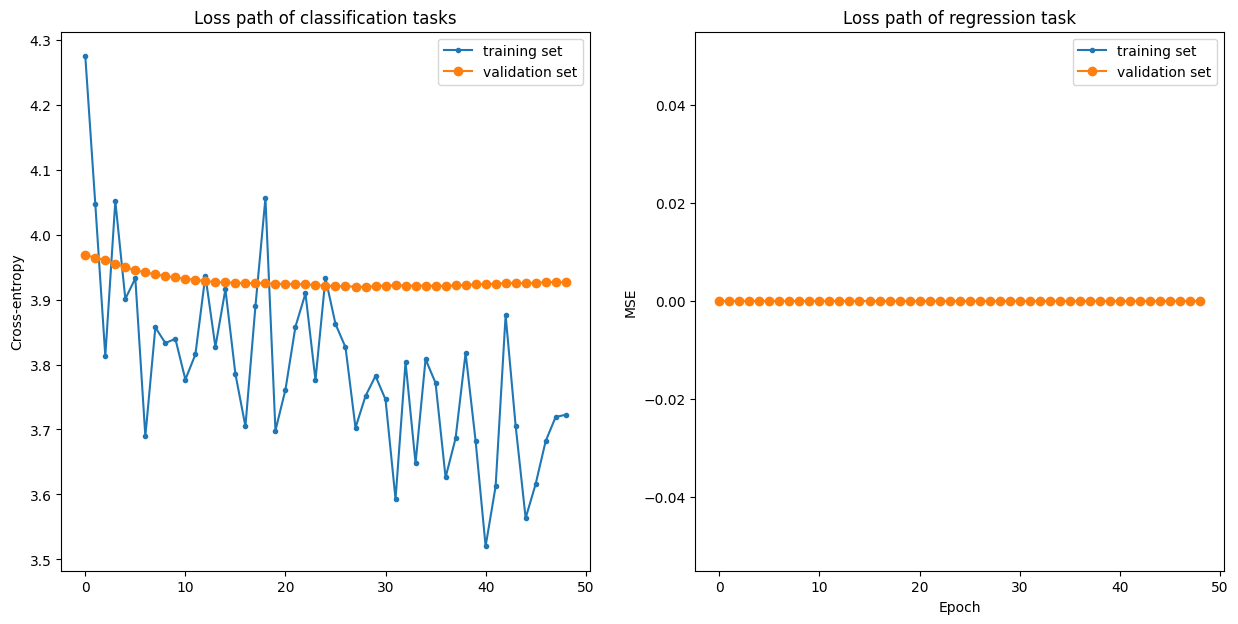

In [42]:
mlhpt_holtwinters.plot()

Now let's use our trained model to predict the best Holt-Winters parameters for the `air_passengers` time series.  The `pred` function returns a `DataFrame` and the predicted parameters are in the `parameters` column.

In [43]:
pred=mlhpt_holtwinters.pred(air_passengers_ts)
pred['parameters'].iloc[0]

{'trend': 'additive',
 'damped': False,
 'seasonal': 'multiplicative',
 'seasonal_periods': 10}

Let's save the model we trained to a file.

In [44]:
mlhpt_holtwinters.save_model("mlhpt_hw.pkl")

Now let's re-load our saved model into a new `MetaLearnHPT` object.

In [45]:
mlhpt_holtwinters3=MetaLearnHPT(load_model=True)
mlhpt_holtwinters3.load_model("mlhpt_hw.pkl")

Let's use our newly loaded model to repeat the prediction we did on the `air_passenger` data set.

In [46]:
pred=mlhpt_holtwinters3.pred(air_passengers_ts)
pred['parameters'].iloc[0]

{'trend': 'additive',
 'damped': False,
 'seasonal': 'multiplicative',
 'seasonal_periods': 10}

### 5.3 `MetaLearnHPT` with Custom Neural Network Model Structure

When using a custom model like we did when initializing `mlhpt_holtwinters2`, you need to specify the model structure by providing the parameters for the neural network to the `build_network` function. 

Here's how we can do that.

In [47]:
mlhpt_holtwinters2.build_network(
    #One shared one-layer NN with 50 neurons.
    n_hidden_shared=[50],
    #Each classification task has its own task-specific NN. In this example, "trend" and "dampled" both have a two-layer NN respectively
    #and "seasonal" has a one-layer NN.
    n_hidden_cat_combo=[[20, 10], [20, 10], [20]], 
    #One task-specific one-layer NN with 30 neurons for regression task.
    n_hidden_num=[30]
)

Multi-task neural network structure:
MultitaskNet(
  (shared_layer): ModuleList(
    (0): Linear(in_features=40, out_features=50, bias=True)
  )
  (cat_layer_combo): ModuleList(
    (0): ModuleList(
      (0): Linear(in_features=50, out_features=20, bias=True)
      (1): Linear(in_features=20, out_features=10, bias=True)
      (2): Linear(in_features=10, out_features=2, bias=True)
    )
    (1): ModuleList(
      (0): Linear(in_features=50, out_features=20, bias=True)
      (1): Linear(in_features=20, out_features=10, bias=True)
      (2): Linear(in_features=10, out_features=2, bias=True)
    )
    (2): ModuleList(
      (0): Linear(in_features=50, out_features=20, bias=True)
      (1): Linear(in_features=20, out_features=2, bias=True)
    )
  )
  (num_layer): ModuleList(
    (0): Linear(in_features=50, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=1, bias=True)
  )
)


Now let's use the `train` function to train the model.  We include some of the extra parameters here to specify how to train the neural network model.

In [48]:
#train the customized NN
mlhpt_holtwinters2.train(    
    #loss_scale is used to balance 2 types of losses: cross-entropy for classification tasks and MSE for regression tasks
    loss_scale=30,
    #learning rate
    lr=0.005,
    n_epochs=2000,
    batch_size=16,
    #supports ADAM and SGD
    method='SGD',
    #momentum in SGD.
    momentum=0,
    #early stop option.
    n_epochs_stop=50,)

Let's look at the training curves for this model.

array([<AxesSubplot: title={'center': 'Loss path of classification tasks'}, ylabel='Cross-entropy'>,
       <AxesSubplot: title={'center': 'Loss path of regression task'}, xlabel='Epoch', ylabel='MSE'>],
      dtype=object)

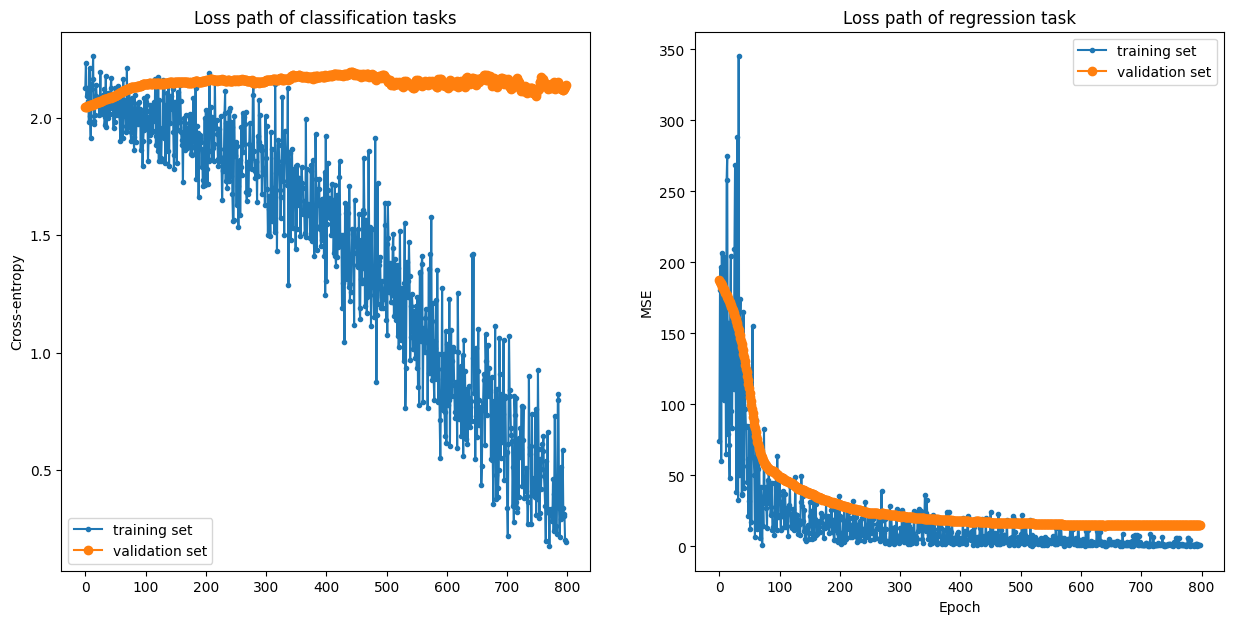

In [49]:
mlhpt_holtwinters2.plot()

Let's use our trained model to predict the best parameters for the `air_passengers` time series. 

In [50]:
pred=mlhpt_holtwinters2.pred(air_passengers_ts)
pred['parameters'].iloc[0]

{'trend': 'multiplicative',
 'damped': False,
 'seasonal': 'multiplicative',
 'seasonal_periods': 454.34265}